In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [9]:
# 1. Import Libraries
print("--- 1. Importing Libraries ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler # Keep commented unless needed for LSTM/XGBoost later
import time

print("Libraries imported successfully.\n")

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")


--- 1. Importing Libraries ---
Libraries imported successfully.



In [11]:
# 2. Load and Prepare Data (Focusing on Weather Features)
print("--- 2. Loading and Preparing Data ---")
file_path = '/content/Full_Merged_AllCities_Energy_Weather (1) (1).csv'
print(f"Loading data from: {file_path}")
df = pd.read_csv(file_path)

# --- Time Column Processing ---
try:
    df['time'] = pd.to_datetime(df['time'], errors='coerce', utc=True)
    df.dropna(subset=['time'], inplace=True) # Crucial: drop rows where time is invalid
    df = df.set_index('time')
    print("Time column processed and set as index.")
except Exception as e:
    print(f"Error processing time column: {e}")
    df = pd.DataFrame() # Ensure df is empty if error occurs

# --- Target Variable Definition ---
# ***************************
# * >>> IMPORTANT: Define Your CORRECT Target Variable HERE <<< *
target = 'total load actual' # CHANGE AS NEEDED (e.g., 'generation solar')
# ***************************

# --- Feature Selection (Weather Only) ---
weather_features = [
    'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
    'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all'
]
print(f"Target variable selected: '{target}'")
print(f"Weather features defined: {weather_features}")

df_filtered = pd.DataFrame() # Initialize empty DataFrame
if not df.empty:
    required_columns = weather_features + [target]
    available_columns = [col for col in required_columns if col in df.columns]
    missing_req_cols = [col for col in required_columns if col not in df.columns]
    if missing_req_cols:
        print(f"\nWarning: Missing required columns (will be excluded): {missing_req_cols}")

    if target not in available_columns:
        print(f"\nFATAL ERROR: Target variable '{target}' is not available. Please check the column name.")
    else:
        columns_to_keep = [col for col in available_columns if col in df.columns]
        df_filtered = df[columns_to_keep].copy()
        print(f"\nFiltered DataFrame created with columns: {columns_to_keep}")
        print("All non-weather and non-target columns REMOVED.")

        # --- Data Cleaning ---
        print("\n--- Data Cleaning ---")
        print("Missing values before handling:\n", df_filtered.isnull().sum().sort_values(ascending=False).head())
        # Fill missing values using forward fill then backward fill
        df_filtered.fillna(method='ffill', inplace=True)
        df_filtered.fillna(method='bfill', inplace=True)
        initial_rows = len(df_filtered)
        df_filtered.dropna(inplace=True) # Drop any remaining NaNs (should be few/none)
        rows_dropped = initial_rows - len(df_filtered)
        print(f"\nMissing values after handling (ffill/bfill). {rows_dropped} rows dropped due to remaining NaNs (if any).")
        print("Remaining missing values:", df_filtered.isnull().sum().sum())

        # --- Data Overview ---
        if not df_filtered.empty:
            print("\nFiltered Dataframe Head:\n", df_filtered.head())
            print("\nFiltered Dataframe Description:")
            # Format description for better readability
            print(df_filtered.describe().to_string())
        else:
            print("\nFiltered DataFrame is empty after cleaning.")
else:
    print("Initial DataFrame empty or time processing failed.")

print("-" * 30 + "\n")


--- 2. Loading and Preparing Data ---
Loading data from: /content/Full_Merged_AllCities_Energy_Weather (1) (1).csv
Time column processed and set as index.
Target variable selected: 'total load actual'
Weather features defined: ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']

Filtered DataFrame created with columns: ['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'total load actual']
All non-weather and non-target columns REMOVED.

--- Data Cleaning ---
Missing values before handling:
 total load actual    180
temp                   0
temp_max               0
temp_min               0
pressure               0
dtype: int64

Missing values after handling (ffill/bfill). 0 rows dropped due to remaining NaNs (if any).
Remaining missing values: 0

Filtered Dataframe Head:
                                  temp    temp_min    temp_ma

<ipython-input-11-d88baa6784a6>:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered.fillna(method='ffill', inplace=True)
<ipython-input-11-d88baa6784a6>:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered.fillna(method='bfill', inplace=True)


--- 3. Exploratory Data Analysis ---

Plotting overall energy target time series...


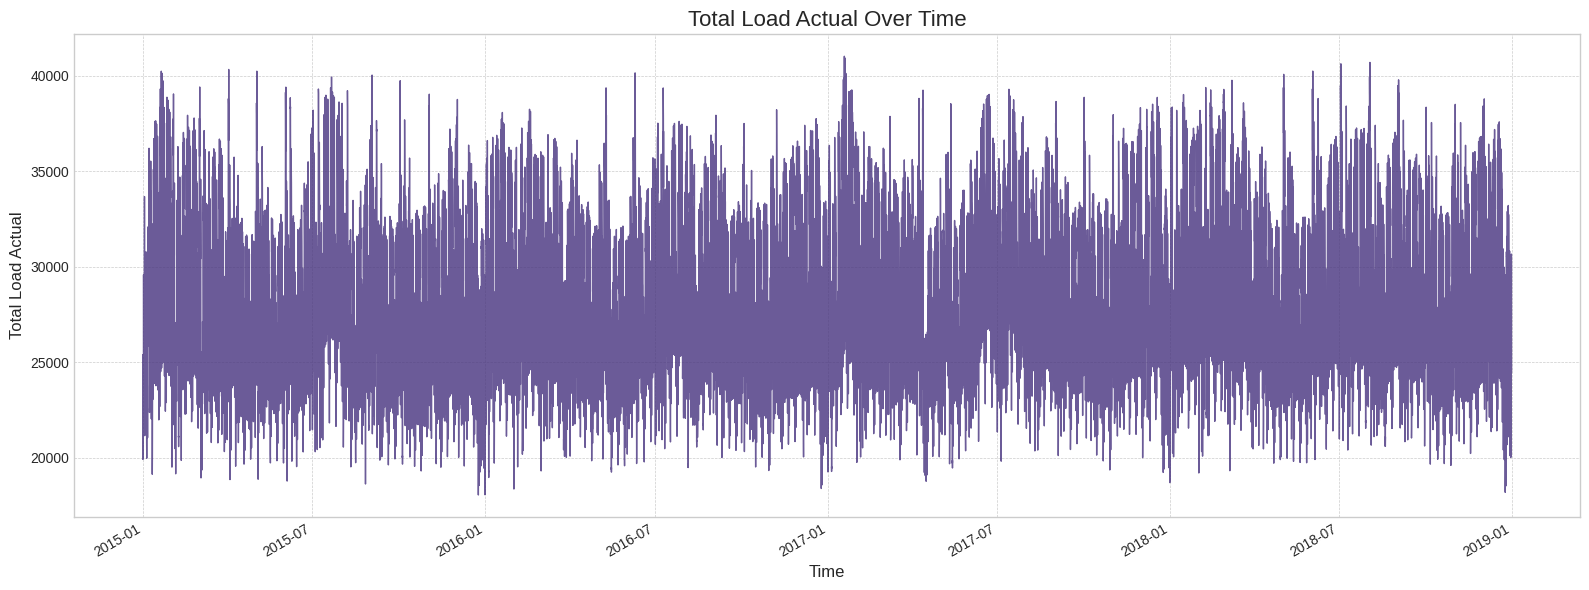


Plotting average daily pattern...


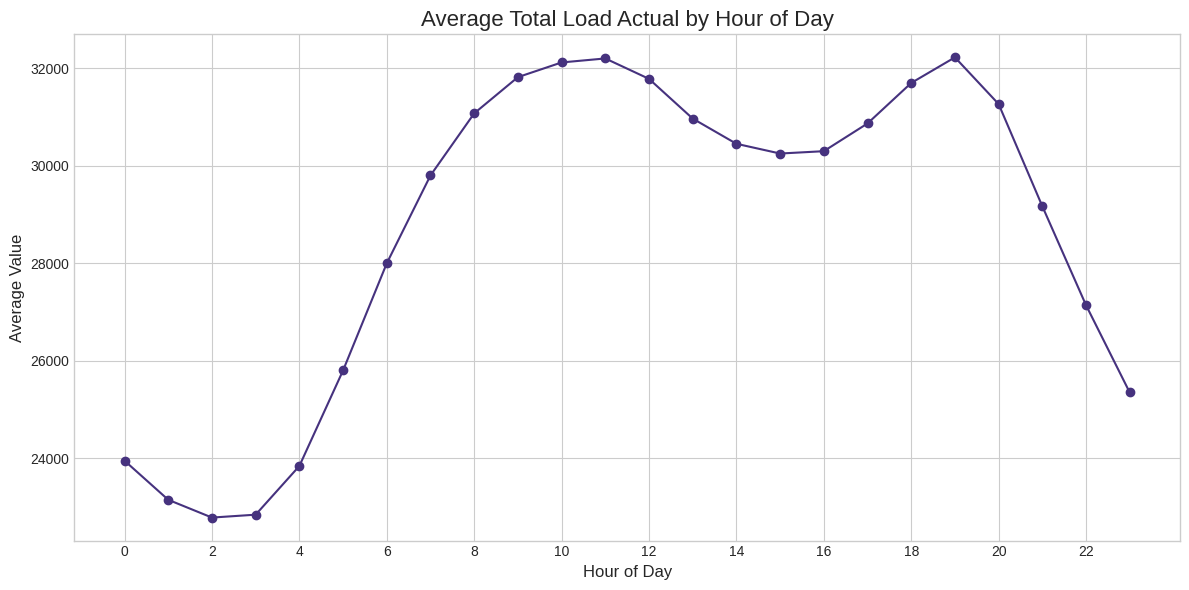


Plotting average monthly pattern...


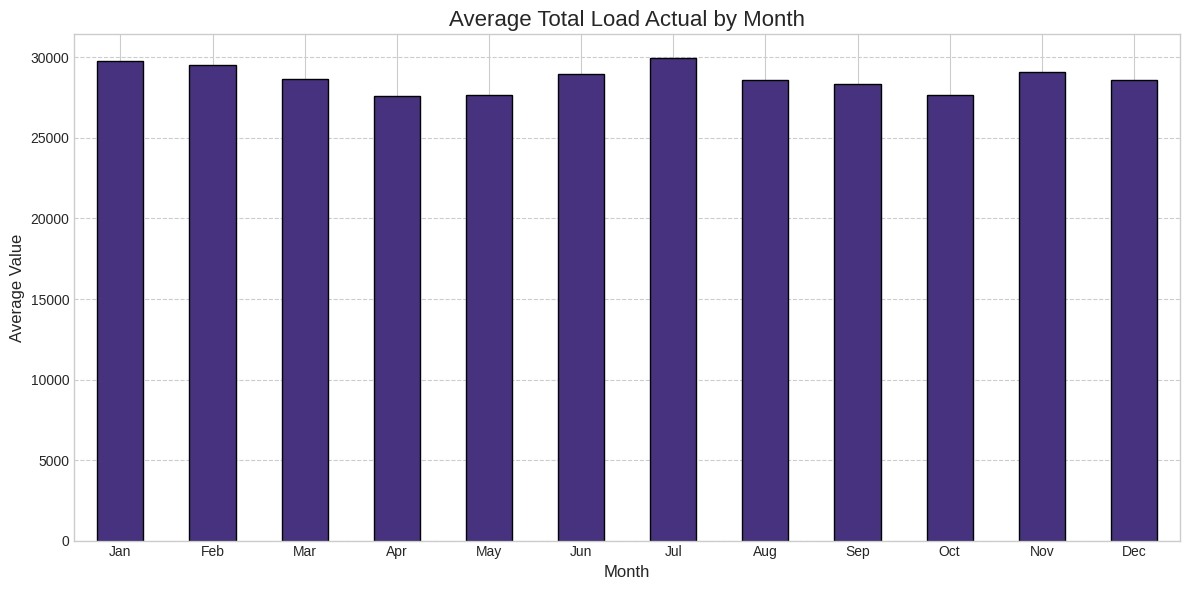


Plotting distribution of key weather features (using defaults/placeholders)...
(Using default features: temp, humidity, clouds_all, wind_speed)


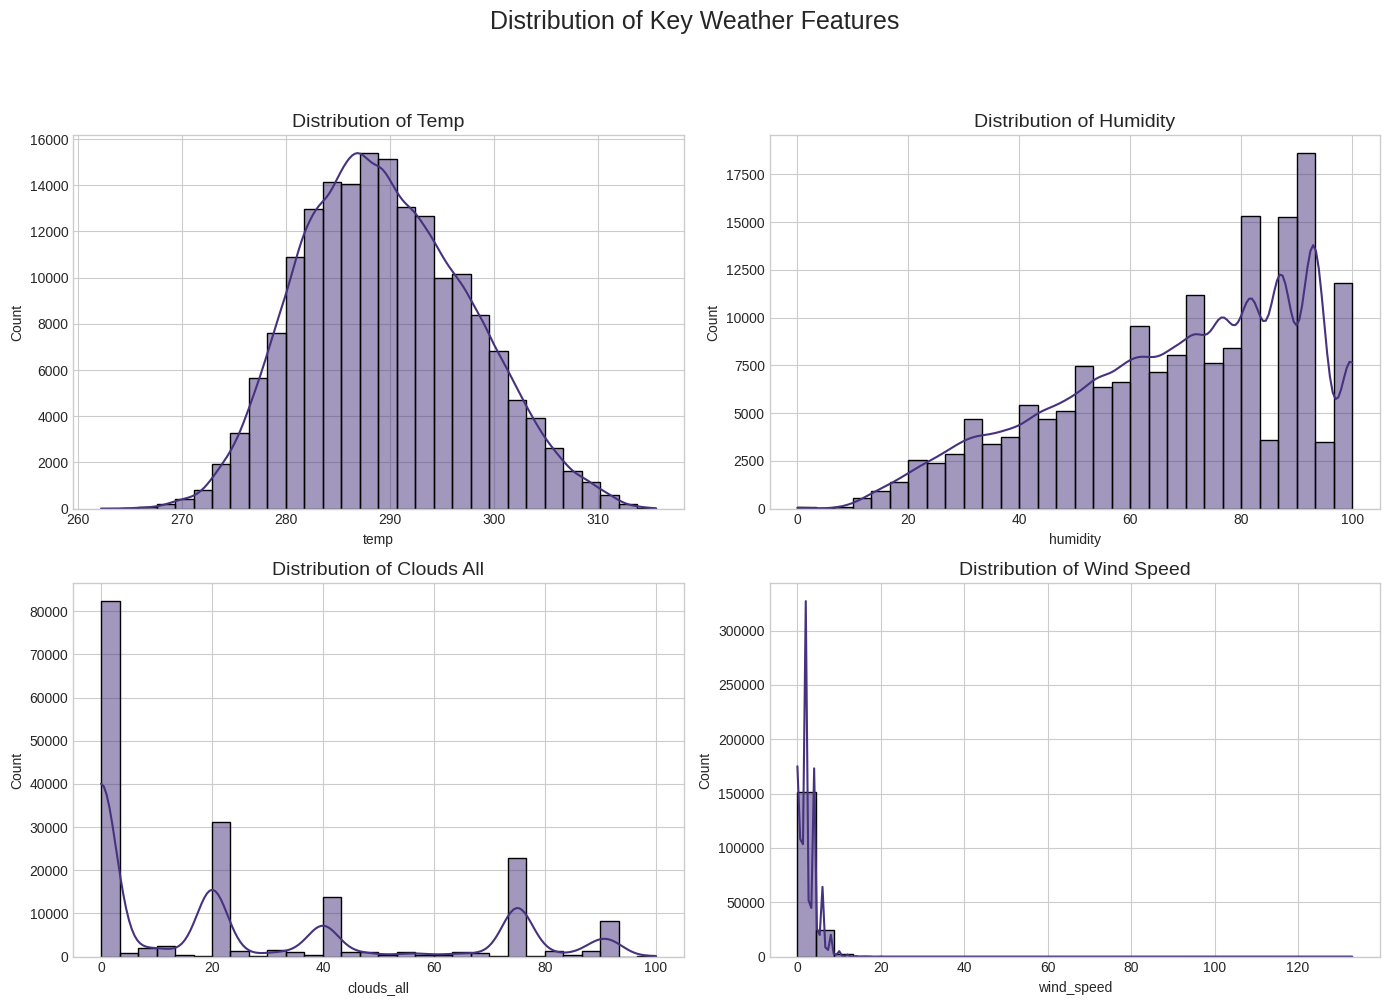

------------------------------



In [12]:
# %%
# 3. Exploratory Data Analysis (EDA)
print("--- 3. Exploratory Data Analysis ---")
if not df_filtered.empty and target in df_filtered.columns:
    # --- Overall Time Series Pattern ---
    print("\nPlotting overall energy target time series...")
    plt.figure(figsize=(16, 6))
    df_filtered[target].plot(alpha=0.8, linewidth=1)
    plt.title(f'{target.replace("_", " ").title()} Over Time', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel(target.replace("_", " ").title(), fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # --- Daily Pattern ---
    print("\nPlotting average daily pattern...")
    plt.figure(figsize=(12, 6))
    hourly_avg = df_filtered.groupby(df_filtered.index.hour)[target].mean()
    hourly_avg.plot(marker='o', linestyle='-')
    plt.title(f'Average {target.replace("_", " ").title()} by Hour of Day', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Average Value', fontsize=12)
    plt.xticks(range(0, 24, 2))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Monthly Pattern ---
    print("\nPlotting average monthly pattern...")
    plt.figure(figsize=(12, 6))
    monthly_avg = df_filtered.groupby(df_filtered.index.month)[target].mean()
    month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    monthly_avg.index = monthly_avg.index.map(month_map)
    monthly_avg.plot(kind='bar', edgecolor='black')
    plt.title(f'Average {target.replace("_", " ").title()} by Month', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Value', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # --- Distribution of Key Weather Features ---
    # (Assuming Feature Importance ran in Sec 4, otherwise use defaults)
    print("\nPlotting distribution of key weather features (using defaults/placeholders)...")
    key_features_to_plot = ['temp', 'humidity', 'clouds_all', 'wind_speed'] # Default selection
    # Check if feature_importance_df exists from Section 4 and use top features if available
    try:
        if not feature_importance_df.empty:
            key_features_to_plot = feature_importance_df['Feature'].head(4).tolist()
            print(f"(Using top features from Section 4: {key_features_to_plot})")
    except NameError:
        print("(Using default features: temp, humidity, clouds_all, wind_speed)")

    num_key_features = len(key_features_to_plot)
    plt.figure(figsize=(14, 5 * ((num_key_features + 1) // 2)))
    for i, feature in enumerate(key_features_to_plot):
        if feature in df_filtered.columns:
            plt.subplot((num_key_features + 1) // 2, 2, i + 1)
            sns.histplot(df_filtered[feature], kde=True, bins=30)
            plt.title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=14)
    plt.suptitle('Distribution of Key Weather Features', fontsize=18, y=1.03)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

else:
    print("Skipping EDA plots as data is empty or target is missing.")
print("-" * 30 + "\n")

--- 4. Weather Impact Analysis ---

Calculating correlation matrix (Weather features vs Target)...


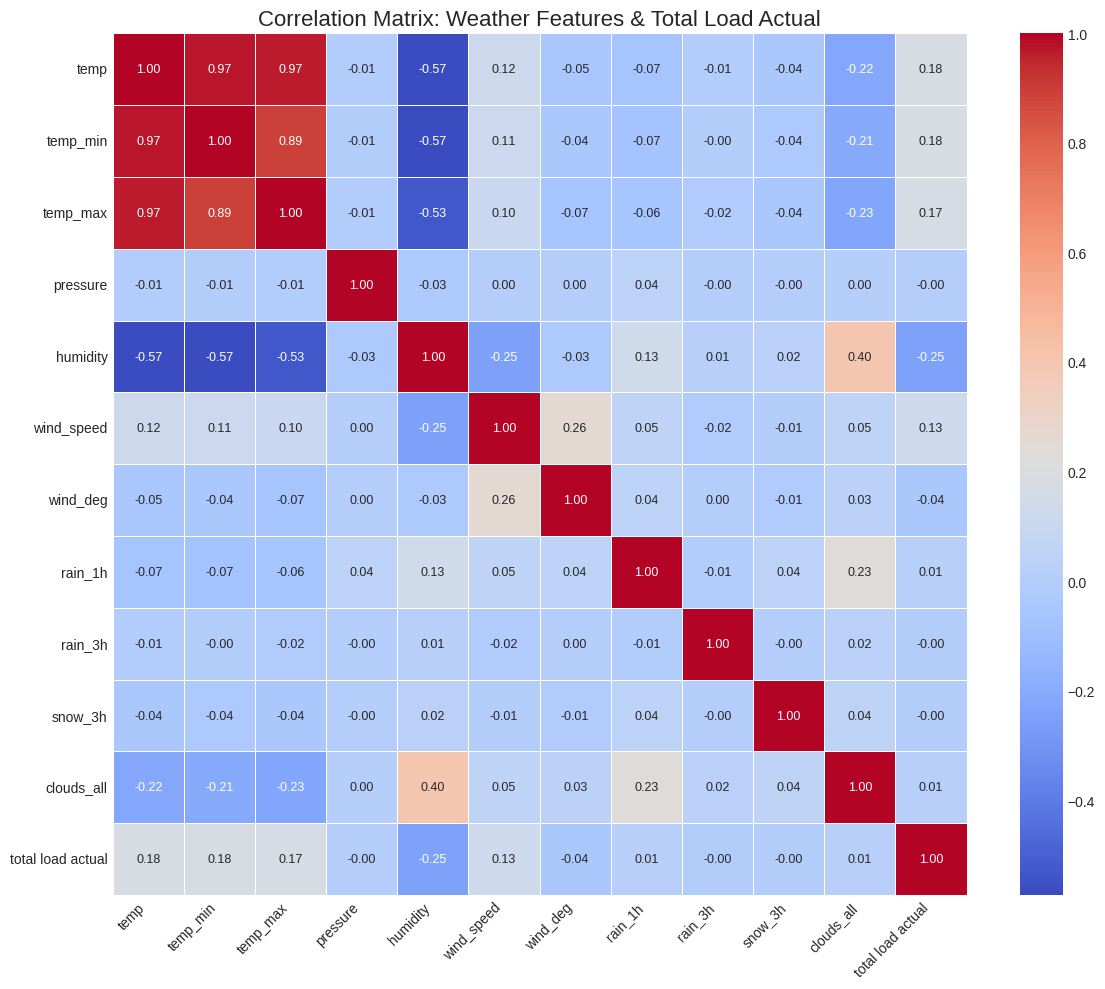


Correlation of Weather Features with Target ('total load actual'):
temp          0.181253
temp_min      0.179381
temp_max      0.170466
wind_speed    0.126261
clouds_all    0.013712
rain_1h       0.012422
pressure     -0.000991
rain_3h      -0.003148
snow_3h      -0.004431
wind_deg     -0.041583
humidity     -0.245273

Calculating Weather Feature Importance using RandomForest...
Training RF model on full data for Feature Importance...
Feature Importance model training complete.

Plotting Weather Feature Importance...


<ipython-input-13-b26d63db8b84>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', orient='h')


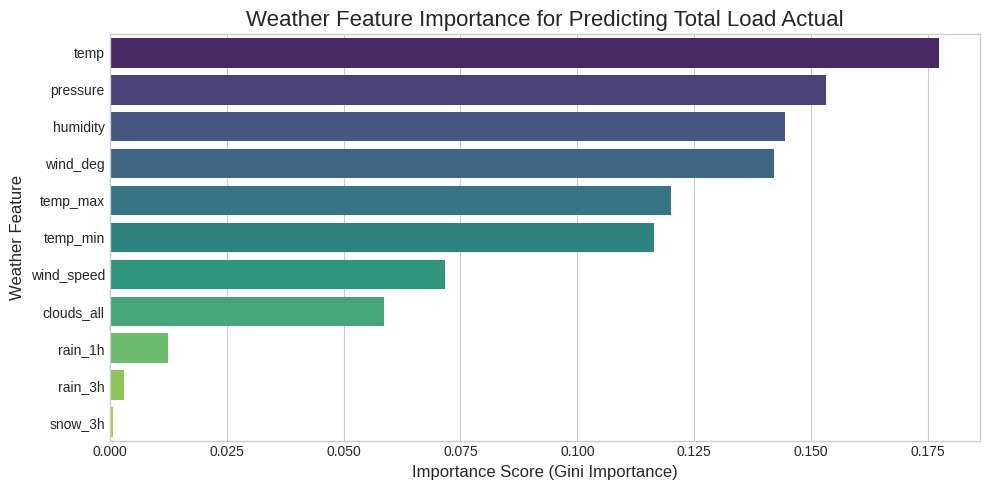


Weather Feature Importances (Ranked):
   Feature  Importance
      temp    0.177239
  pressure    0.153254
  humidity    0.144501
  wind_deg    0.141997
  temp_max    0.119963
  temp_min    0.116413
wind_speed    0.071606
clouds_all    0.058682
   rain_1h    0.012560
   rain_3h    0.003064
   snow_3h    0.000722
------------------------------



In [13]:

# %%


# %%


# %%
# 4. Analyze Weather Impact (Correlation & RF Feature Importance)
print("--- 4. Weather Impact Analysis ---")
feature_importance_df = pd.DataFrame() # Initialize/reset

if not df_filtered.empty and target in df_filtered.columns:
    df_numeric = df_filtered.select_dtypes(include=np.number).copy()
    current_weather_features = [col for col in weather_features if col in df_numeric.columns]

    if df_numeric.empty or not current_weather_features:
        print("No numeric weather features or target available for analysis.")
    else:
        # --- Correlation Analysis ---
        print("\nCalculating correlation matrix (Weather features vs Target)...")
        correlation_matrix = df_numeric.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 9})
        plt.title(f'Correlation Matrix: Weather Features & {target.replace("_", " ").title()}', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        if target in correlation_matrix:
            print(f"\nCorrelation of Weather Features with Target ('{target}'):")
            target_correlations = correlation_matrix[target].drop(target).sort_values(ascending=False)
            print(target_correlations.to_string())
        else:
             print(f"\nWarning: Target '{target}' not found in correlation matrix.")

        # --- Feature Importance Analysis (Random Forest on Weather Features) ---
        print("\nCalculating Weather Feature Importance using RandomForest...")
        X_fi = df_numeric[current_weather_features]
        y_fi = df_numeric[target]

        if not X_fi.empty and not y_fi.empty:
            rf_fi_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_features=0.5)
            print("Training RF model on full data for Feature Importance...")
            rf_fi_model.fit(X_fi, y_fi)
            print("Feature Importance model training complete.")

            importances = rf_fi_model.feature_importances_
            feature_importance_df = pd.DataFrame({'Feature': current_weather_features, 'Importance': importances})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

            # --- Plotting Weather Feature Importance ---
            print("\nPlotting Weather Feature Importance...")
            plt.figure(figsize=(10, max(5, len(current_weather_features)*0.4))) # Adjust height dynamically
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', orient='h')
            plt.title(f'Weather Feature Importance for Predicting {target.replace("_", " ").title()}', fontsize=16)
            plt.xlabel('Importance Score (Gini Importance)', fontsize=12)
            plt.ylabel('Weather Feature', fontsize=12)
            plt.tight_layout()
            plt.show() # <<< THIS PLOT SHOULD APPEAR

            print("\nWeather Feature Importances (Ranked):")
            print(feature_importance_df.to_string(index=False))
        else:
            print("Feature set or target is empty. Skipping Feature Importance calculation.")
else:
    print("Weather impact analysis skipped due to empty data or missing target.")
print("-" * 30 + "\n")






--- 5. Model Tuning, Training & Evaluation ---
Using features for modeling: ['temp', 'pressure', 'humidity', 'wind_deg', 'temp_max', 'temp_min', 'wind_speed', 'clouds_all', 'rain_1h', 'rain_3h', 'snow_3h']

Using TimeSeriesSplit with 5 splits for cross-validation during tuning.

Setting up GridSearchCV for RandomForestRegressor...
Running GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
GridSearchCV finished in 955.64 seconds.

Best Parameters found:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}

Data split into Training (142716 samples) and Test (35680 samples) for final evaluation.
Making predictions on the Test Set...

--- Tuned Model Performance Metrics (Test Set) ---
  Best RF Parameters Found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
  R-squared (R²): 0.1979
  Root Mean Squared Error (RMSE): 4051.5117
-------------------------------------------------

Generating Me

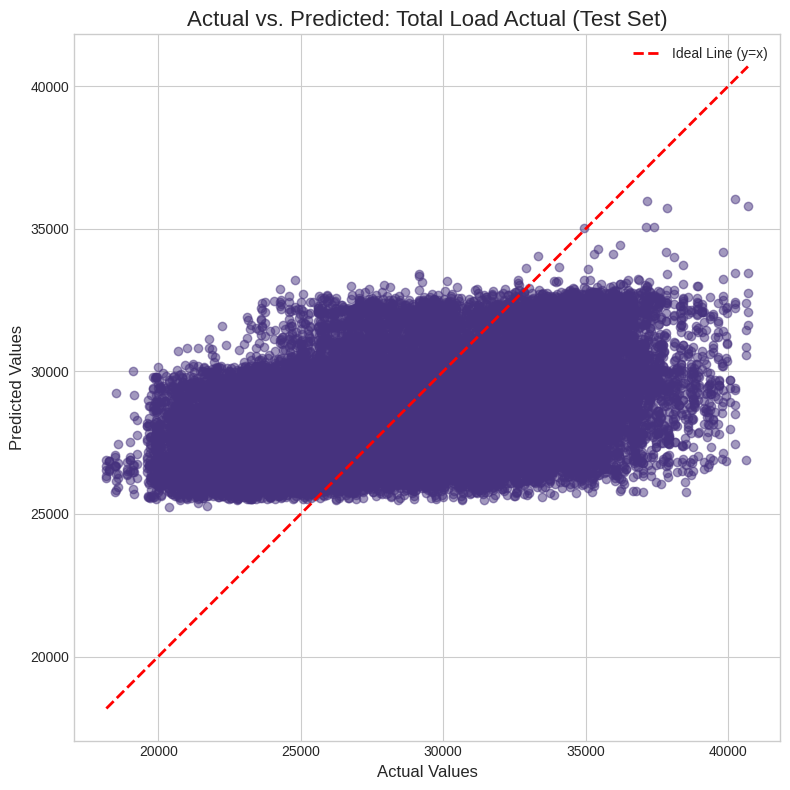

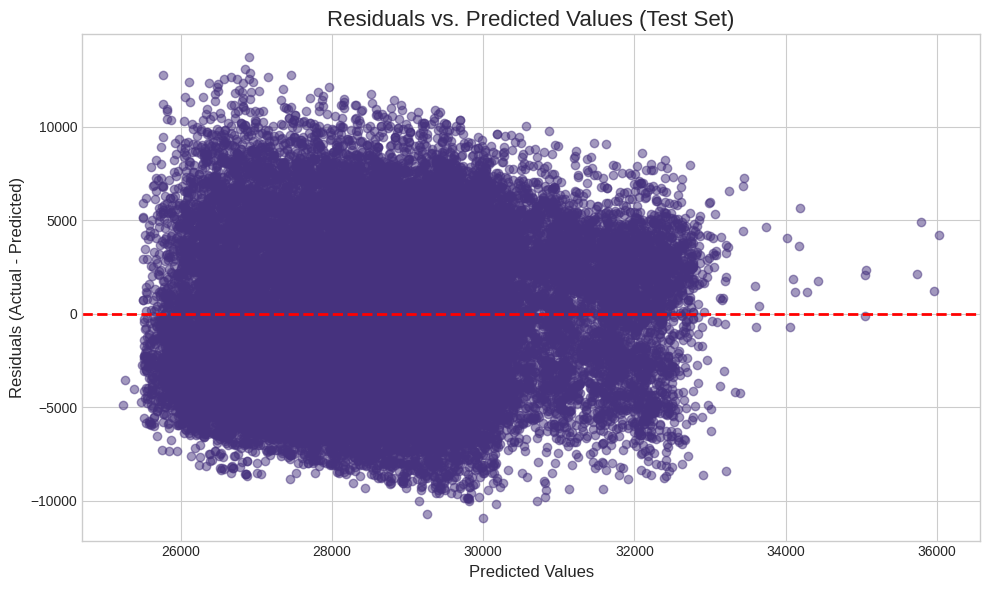

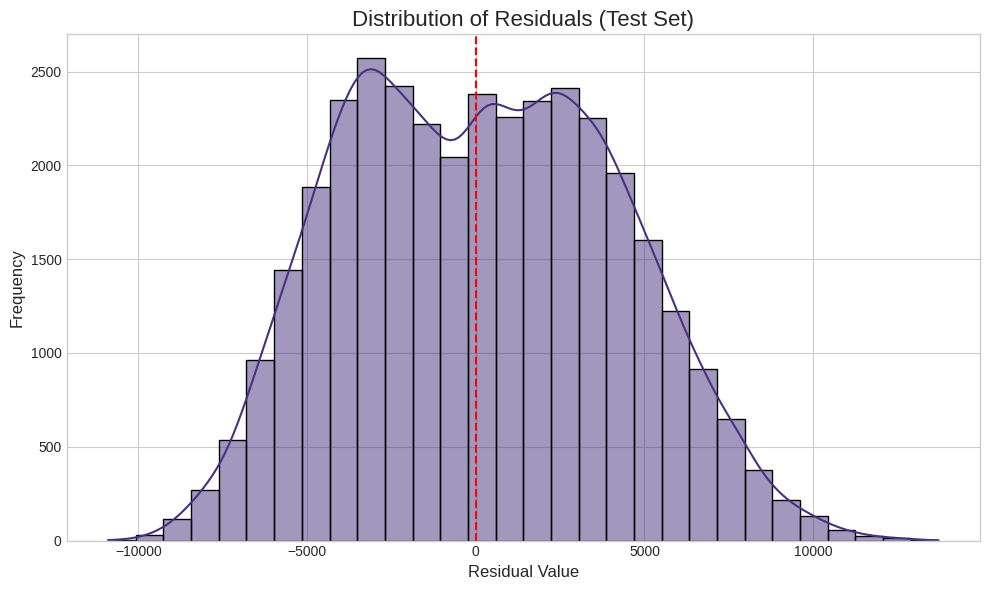

------------------------------



In [14]:
# %%
# 5. Time Series Model: Tuning, Training, Evaluation (Weather Features Only)
print("--- 5. Model Tuning, Training & Evaluation ---")

# Check if necessary data exists from previous steps
if not df_filtered.empty and target in df_filtered.columns and not feature_importance_df.empty:
    df_numeric = df_filtered.select_dtypes(include=np.number).copy()
    # Use features identified as important (or all available if FI failed)
    current_weather_features = feature_importance_df['Feature'].tolist() if not feature_importance_df.empty else [col for col in weather_features if col in df_numeric.columns]

    if not current_weather_features:
        print("No weather features identified. Skipping model training.")
    else:
        print(f"Using features for modeling: {current_weather_features}")
        X = df_numeric[current_weather_features]
        y = df_numeric[target]

        # --- Time Series Split ---
        n_splits = 5 # Number of splits for CV
        tscv = TimeSeriesSplit(n_splits=n_splits)
        print(f"\nUsing TimeSeriesSplit with {n_splits} splits for cross-validation during tuning.")

        # --- Hyperparameter Tuning (GridSearchCV) ---
        print("\nSetting up GridSearchCV for RandomForestRegressor...")
        # Define a slightly smaller parameter grid for faster execution
        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [5, 10],
            'max_features': ['sqrt', 0.5]
        }
        rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
        grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='r2', verbose=1)

        print("Running GridSearchCV...")
        start_time = time.time()
        # Use try-except for robustness during fit
        try:
             grid_search.fit(X, y) # Fit on the entire data for finding best params via CV
             end_time = time.time()
             print(f"GridSearchCV finished in {end_time - start_time:.2f} seconds.")
             print("\nBest Parameters found:")
             print(grid_search.best_params_)
             best_rf_model = grid_search.best_estimator_
        except Exception as e:
             print(f"Error during GridSearchCV: {e}")
             print("Using default RF model instead.")
             best_rf_model = RandomForestRegressor(random_state=42, n_jobs=-1) # Fallback

        # --- Final Train/Test Split for Evaluation ---
        test_size_fraction = 0.2
        split_index = int(len(X) * (1 - test_size_fraction))
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
        print(f"\nData split into Training ({len(X_train)} samples) and Test ({len(X_test)} samples) for final evaluation.")

        # --- Train Final Model (if not already done by GridSearchCV refit=True) ---
        # If GridSearchCV failed, fit the default model
        if 'grid_search' not in locals() or not hasattr(grid_search, 'best_estimator_'):
             print(f"Training default RF model on the Training Set...")
             best_rf_model.fit(X_train, y_train)
        # If GridSearchCV succeeded, it usually refits the best model on all data passed to fit.
        # For evaluation consistency, some prefer to explicitly fit only on X_train here:
        # print(f"Explicitly fitting the best model on the Training Set...")
        # best_rf_model.fit(X_train, y_train) # Uncomment this line if you prefer strict train/test separation after tuning

        # --- Make Predictions ---
        print("Making predictions on the Test Set...")
        try:
            y_pred = best_rf_model.predict(X_test)

            # --- Calculate Metrics ---
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            print("\n--- Tuned Model Performance Metrics (Test Set) ---")
            try:
                 print(f"  Best RF Parameters Found: {grid_search.best_params_}")
            except NameError:
                 print("  Best RF Parameters: Default (GridSearch failed or skipped)")
            print(f"  R-squared (R²): {r2:.4f}") # <<< METRICS OUTPUT
            print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}") # <<< METRICS OUTPUT
            print("-------------------------------------------------")

            # --- Generate Metric Plots ---
            print("\nGenerating Metric Plots for the Tuned Model...")

            # 1. Actual vs. Predicted Plot
            plt.figure(figsize=(8, 8))
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='red', label='Ideal Line (y=x)')
            plt.xlabel("Actual Values", fontsize=12)
            plt.ylabel("Predicted Values", fontsize=12)
            plt.title(f'Actual vs. Predicted: {target.replace("_", " ").title()} (Test Set)', fontsize=16)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show() # <<< PLOT 1

            # 2. Residuals vs. Predicted Plot
            residuals = y_test - y_pred
            plt.figure(figsize=(10, 6))
            plt.scatter(y_pred, residuals, alpha=0.5)
            plt.axhline(0, color='red', linestyle='--', lw=2)
            plt.xlabel("Predicted Values", fontsize=12)
            plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
            plt.title('Residuals vs. Predicted Values (Test Set)', fontsize=16)
            plt.grid(True)
            plt.tight_layout()
            plt.show() # <<< PLOT 2

            # 3. Residuals Distribution Plot
            plt.figure(figsize=(10, 6))
            sns.histplot(residuals, kde=True, bins=30)
            plt.xlabel("Residual Value", fontsize=12)
            plt.ylabel("Frequency", fontsize=12)
            plt.title('Distribution of Residuals (Test Set)', fontsize=16)
            plt.axvline(0, color='red', linestyle='--')
            plt.tight_layout()
            plt.show() # <<< PLOT 3

        except Exception as e:
            print(f"Error during prediction or plotting: {e}")

else:
    print("Model training, tuning and evaluation skipped due to missing data or prior errors.")
print("-" * 30 + "\n")


--- 6. Visualizing Impact of Top Weather Features ---
Plotting target ('total load actual') against top 3 weather features: ['temp', 'pressure', 'humidity']


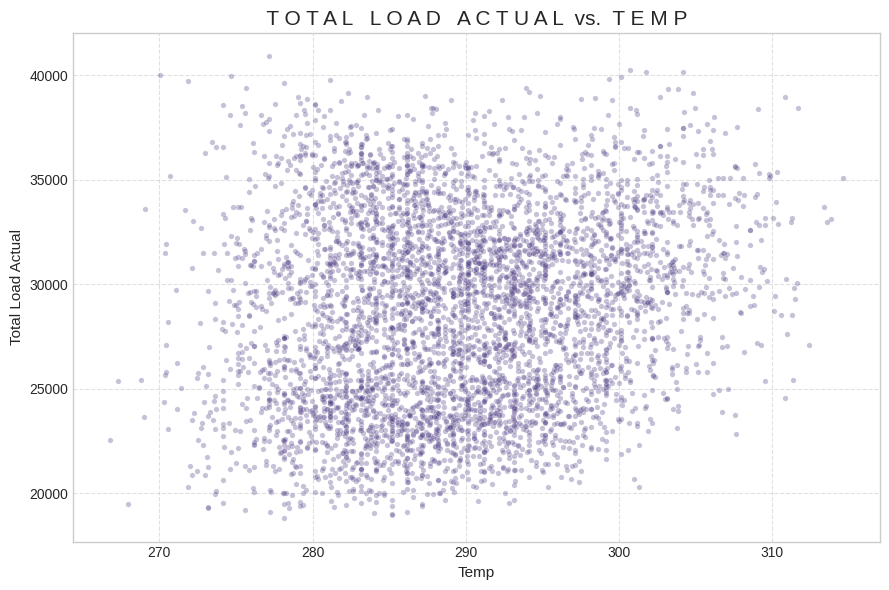

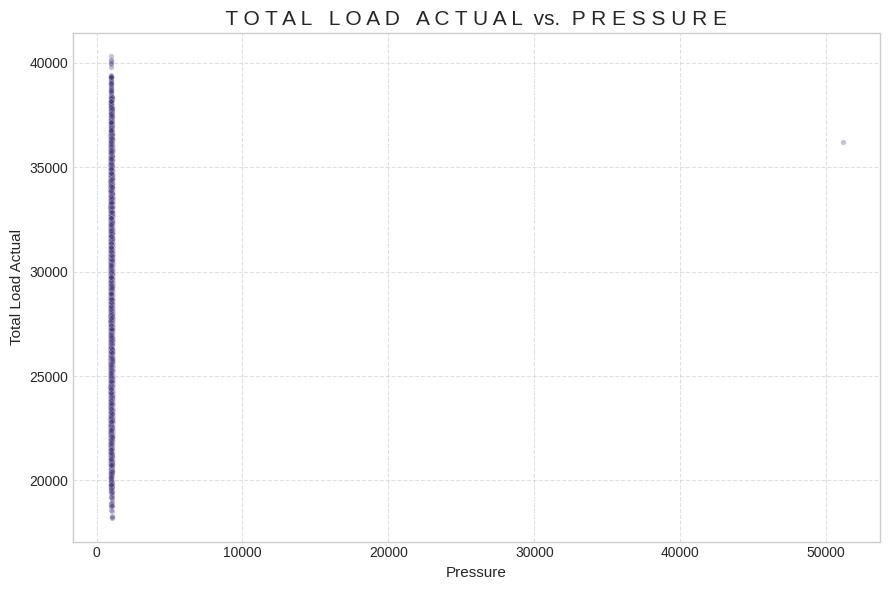

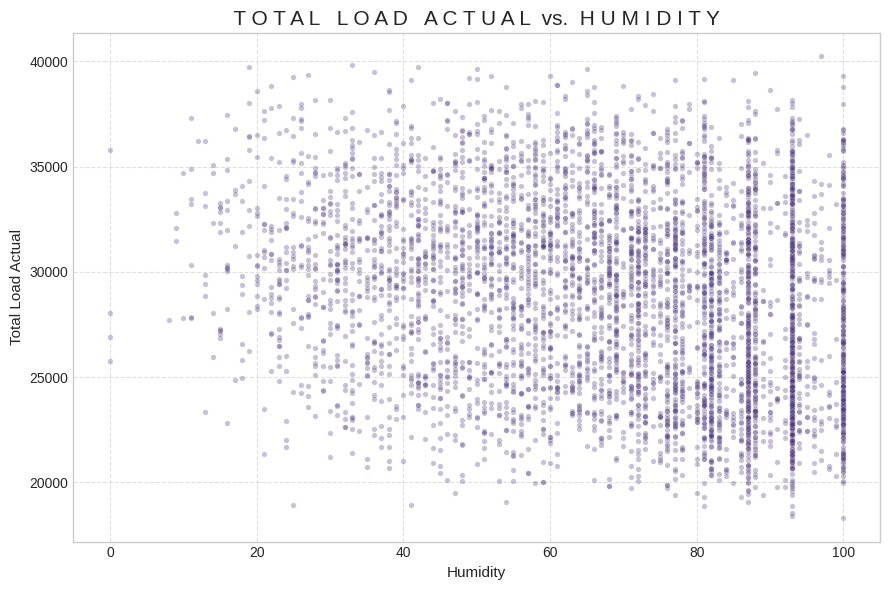

------------------------------



In [15]:
# %%
# 6. Weather Impact Scatter Plots (Using Top Features from Sec 4)
print("--- 6. Visualizing Impact of Top Weather Features ---")
if not df_filtered.empty and target in df_filtered.columns and not feature_importance_df.empty:
    top_n = min(3, len(feature_importance_df)) # Show top 3 or fewer if less features
    top_features = feature_importance_df['Feature'].head(top_n).tolist()
    print(f"Plotting target ('{target}') against top {top_n} weather features: {top_features}")

    for feature in top_features:
        if feature in df_filtered.columns:
            plt.figure(figsize=(9, 6))
            # Use sample for large datasets to avoid clutter
            sample_df = df_filtered.sample(min(len(df_filtered), 5000)) if len(df_filtered) > 5000 else df_filtered
            sns.scatterplot(data=sample_df, x=feature, y=target, alpha=0.3, s=15) # smaller points
            plt.title(f'{target.replace("", " ").title()} vs. {feature.replace("", " ").title()}', fontsize=15)
            plt.xlabel(feature.replace("_", " ").title(), fontsize=11)
            plt.ylabel(target.replace("_", " ").title(), fontsize=11)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show() # <<< PLOT 4, 5, 6 (potentially)
        else:
            print(f"Warning: Feature '{feature}' not found for plotting.")
else:
    print("Scatter plots skipped due to missing data or feature importance results.")
print("-" * 30 + "\n")





--- 7.1 Implementing XGBoost ---
Stored previous Random Forest results.

Setting up GridSearchCV for XGBoost Regressor...
Running GridSearchCV for XGBoost (this might take some time)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
XGBoost GridSearchCV finished in 216.40 seconds.

Best Parameters found for XGBoost:
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}

Evaluating the best XGBoost model on the Test Set...

--- Tuned XGBoost Performance Metrics (Test Set) ---
  Best XGB Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
  R-squared (R²): 0.1662
  Root Mean Squared Error (RMSE): 4130.8827
-------------------------------------------------

Plotting XGBoost Feature Importance...


<ipython-input-16-f92ef8fed1ca>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_importance_df, palette='viridis', orient='h')


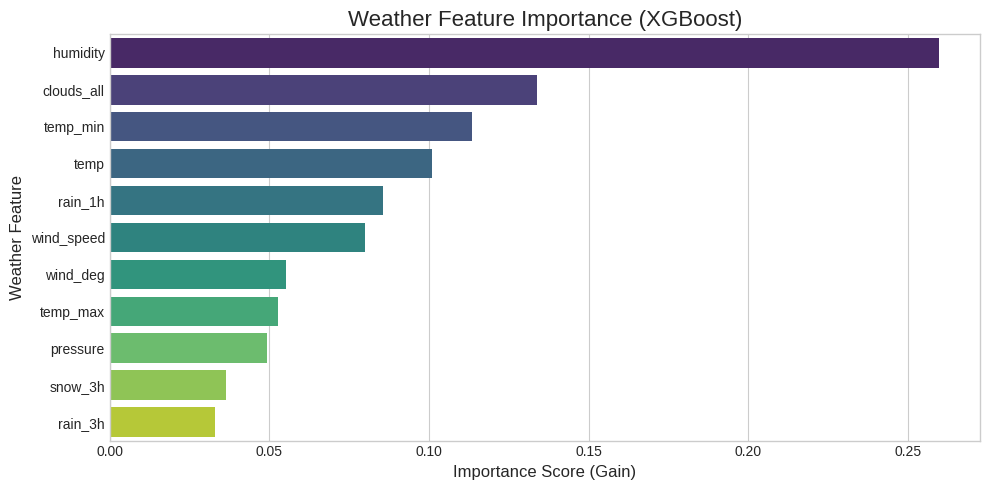


XGBoost Feature Importances (Ranked):
   Feature  Importance
  humidity    0.259508
clouds_all    0.133684
  temp_min    0.113576
      temp    0.100907
   rain_1h    0.085607
wind_speed    0.079995
  wind_deg    0.055179
  temp_max    0.052746
  pressure    0.049321
   snow_3h    0.036458
   rain_3h    0.033021


In [16]:
# # 7. Adding and Comparing Other Models (XGBoost & LSTM)
#
# Now, we implement XGBoost and LSTM models using the same time-series split and weather-only features for comparison with the tuned Random Forest.

# %%
# 7.1 XGBoost Implementation
print("\n--- 7.1 Implementing XGBoost ---")

# Import XGBoost
try:
    import xgboost as xgb
except ImportError:
    print("XGBoost not installed. Please install it: pip install xgboost")
    # Optionally skip XGBoost if not installed
    xgb = None

model_results = {} # Initialize dictionary to store results
# Get RF results from previous step (assuming they exist)
try:
    # Make sure 'r2' and 'rmse' variables from Section 5 are accessible
    # Or re-calculate if necessary based on best_rf_model predictions
    # For safety, let's assume best_rf_model and test data are available
    y_pred_rf = best_rf_model.predict(X_test) # Re-predict just in case
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    model_results['RandomForest_Tuned'] = {'R2': r2_rf, 'RMSE': rmse_rf}
    print("Stored previous Random Forest results.")
except NameError:
    print("Warning: Could not find results from previous RF model ('best_rf_model'). Ensure Section 5 ran.")
    # Initialize with NaNs or handle appropriately
    model_results['RandomForest_Tuned'] = {'R2': np.nan, 'RMSE': np.nan}


if xgb:
    print("\nSetting up GridSearchCV for XGBoost Regressor...")
    # Define parameter grid for XGBoost
    xgb_param_grid = {
        'n_estimators': [100, 200], # Number of boosting rounds
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 1.0], # Fraction of samples used per tree
        'colsample_bytree': [0.7, 1.0] # Fraction of features used per tree
    }

    # Initialize XGBoost Regressor
    xgb_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

    # Setup GridSearchCV with TimeSeriesSplit
    xgb_grid_search = GridSearchCV(estimator=xgb_base, param_grid=xgb_param_grid,
                                   cv=tscv, n_jobs=-1, scoring='r2', verbose=1)

    print("Running GridSearchCV for XGBoost (this might take some time)...")
    start_time = time.time()
    try:
        xgb_grid_search.fit(X_train, y_train) # Fit on training data for tuning
        end_time = time.time()
        print(f"XGBoost GridSearchCV finished in {end_time - start_time:.2f} seconds.")

        print("\nBest Parameters found for XGBoost:")
        print(xgb_grid_search.best_params_)
        best_xgb_model = xgb_grid_search.best_estimator_

        # --- Evaluate Best XGBoost Model ---
        print("\nEvaluating the best XGBoost model on the Test Set...")
        y_pred_xgb = best_xgb_model.predict(X_test)

        # Calculate Metrics
        r2_xgb = r2_score(y_test, y_pred_xgb)
        rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
        model_results['XGBoost_Tuned'] = {'R2': r2_xgb, 'RMSE': rmse_xgb}

        print("\n--- Tuned XGBoost Performance Metrics (Test Set) ---")
        print(f"  Best XGB Parameters: {xgb_grid_search.best_params_}")
        print(f"  R-squared (R²): {r2_xgb:.4f}")
        print(f"  Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
        print("-------------------------------------------------")

        # --- XGBoost Feature Importance ---
        print("\nPlotting XGBoost Feature Importance...")
        xgb_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': best_xgb_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, max(5, len(xgb_importance_df)*0.4)))
        sns.barplot(x='Importance', y='Feature', data=xgb_importance_df, palette='viridis', orient='h')
        plt.title('Weather Feature Importance (XGBoost)', fontsize=16)
        plt.xlabel('Importance Score (Gain)', fontsize=12)
        plt.ylabel('Weather Feature', fontsize=12)
        plt.tight_layout()
        plt.show()

        print("\nXGBoost Feature Importances (Ranked):")
        print(xgb_importance_df.to_string(index=False))

    except Exception as e:
        print(f"\nError during XGBoost training/evaluation: {e}")
        model_results['XGBoost_Tuned'] = {'R2': np.nan, 'RMSE': np.nan}







--- 7.2 Implementing LSTM ---

Preprocessing data for LSTM...
Features scaled using MinMaxScaler.
Target variable scaled using MinMaxScaler.
Creating sequences with lookback = 10 steps...
Shape of X_train sequences: (142706, 10, 11)
Shape of y_train sequences: (142706, 1)
Shape of X_test sequences: (35670, 10, 11)
Shape of y_test sequences: (35670, 1)

Defining LSTM model architecture...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,451 (48.64 KB)

 Trainable params: 12,451 (48.64 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/50
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - loss: 0.0392 - val_loss: 0.0303
Epoch 2/50
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.0312 - val_loss: 0.0289
Epoch 3/50
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 0.0295 - val_loss: 0.0292
Epoch 4/50
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.0287 - val_loss: 0.0282
Epoch 5/50
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.0279 - val_loss: 0.0288
Epoch 6/50
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 0.0276 - val_loss: 0.0290
Epoch 7/50
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 0.0271 - val_loss: 0.0288
Epoch 8/50
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - loss: 0.0267 - val_loss: 0.0281
Epoch 9/50
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - loss: 0.0262 - val_loss: 0.0280
Epoch 10/50
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - loss: 0.0258 - val_loss: 0.0291
Epoch 11/50
4460/4460 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - loss: 0.0253 - val_loss: 0.

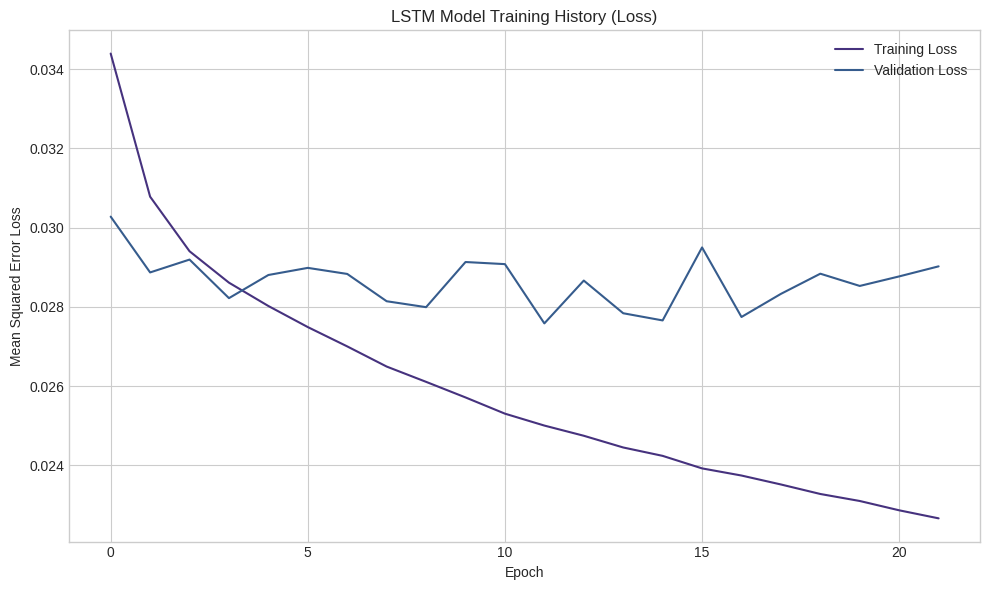


Evaluating the LSTM model on the Test Set...
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

--- LSTM Performance Metrics (Test Set) ---
  R-squared (R²): 0.2888
  Root Mean Squared Error (RMSE): 3815.4632
-------------------------------------------


In [17]:
# %%
# 7.2 LSTM Implementation
print("\n--- 7.2 Implementing LSTM ---")

# Import necessary libraries
try:
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Input
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.preprocessing import MinMaxScaler # MinMaxScaler often preferred for LSTMs
    tf_installed = True
except ImportError:
    print("TensorFlow/Keras not installed. Please install it: pip install tensorflow")
    tf_installed = False

if tf_installed and not X_train.empty: # Check if data is available

    # --- LSTM Data Preprocessing ---
    print("\nPreprocessing data for LSTM...")

    # 1. Scaling Features (Crucial for LSTMs)
    # Use MinMaxScaler: Scales data to range [0, 1]
    feature_scaler = MinMaxScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    print("Features scaled using MinMaxScaler.")

    # 2. Scaling Target (Optional but often recommended)
    target_scaler = MinMaxScaler()
    # Reshape y to 2D array for scaler: (n_samples, 1)
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    print("Target variable scaled using MinMaxScaler.")

    # 3. Reshaping Data into Sequences
    # Define sequence length (number of past time steps to look back)
    n_steps = 10 # Example: look back 10 hours/time steps
    n_features = X_train_scaled.shape[1] # Number of weather features

    # Helper function to create sequences
    def create_sequences(X, y, n_steps):
        X_seq, y_seq = [], []
        for i in range(len(X) - n_steps):
            end_ix = i + n_steps
            # Features sequence: X[i:end_ix]
            # Target: y[end_ix] (predict the step immediately after the sequence)
            X_seq.append(X[i:end_ix])
            y_seq.append(y[end_ix])
        return np.array(X_seq), np.array(y_seq)

    print(f"Creating sequences with lookback = {n_steps} steps...")
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)

    # Check shapes: (samples, timesteps, features) for X, (samples, 1) for y
    print(f"Shape of X_train sequences: {X_train_seq.shape}")
    print(f"Shape of y_train sequences: {y_train_seq.shape}")
    print(f"Shape of X_test sequences: {X_test_seq.shape}")
    print(f"Shape of y_test sequences: {y_test_seq.shape}")

    if X_train_seq.shape[0] == 0:
         print("ERROR: No sequences created. Check data length and n_steps.")
    else:
        # --- Define LSTM Model ---
        print("\nDefining LSTM model architecture...")
        lstm_model = Sequential([
            Input(shape=(n_steps, n_features)), # Define input shape
            LSTM(units=50, activation='relu', return_sequences=False), # 50 LSTM units, return only last output
            # Add more layers if needed: LSTM(units=..., activation='relu', return_sequences=True),
            Dense(units=1) # Output layer: 1 neuron for regression target
        ])
        lstm_model.compile(optimizer='adam', loss='mse') # Use Mean Squared Error for regression loss
        lstm_model.summary()

        # --- Train LSTM Model ---
        print("\nTraining LSTM model...")
        # Use early stopping to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        # Use the test sequences as validation data during training
        history = lstm_model.fit(X_train_seq, y_train_seq,
                                 epochs=50, # Adjust epochs as needed
                                 batch_size=32, # Adjust batch size as needed
                                 validation_data=(X_test_seq, y_test_seq),
                                 callbacks=[early_stopping],
                                 verbose=1) # verbose=1 shows progress

        # Plot training & validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('LSTM Model Training History (Loss)')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # --- Evaluate LSTM Model ---
        print("\nEvaluating the LSTM model on the Test Set...")
        # Predict on test sequences
        y_pred_scaled_lstm = lstm_model.predict(X_test_seq)

        # Inverse transform predictions and actual values to original scale
        y_pred_lstm = target_scaler.inverse_transform(y_pred_scaled_lstm)
        y_test_orig_lstm = target_scaler.inverse_transform(y_test_seq) # Use the corresponding y_test sequences

        # Calculate Metrics
        r2_lstm = r2_score(y_test_orig_lstm, y_pred_lstm)
        rmse_lstm = np.sqrt(mean_squared_error(y_test_orig_lstm, y_pred_lstm))
        model_results['LSTM'] = {'R2': r2_lstm, 'RMSE': rmse_lstm}

        print("\n--- LSTM Performance Metrics (Test Set) ---")
        print(f"  R-squared (R²): {r2_lstm:.4f}")
        print(f"  Root Mean Squared Error (RMSE): {rmse_lstm:.4f}")
        print("-------------------------------------------")

        # Note: Feature importance for LSTM is complex and not directly computed here.
        # Techniques like Permutation Importance or SHAP could be explored separately if needed.

else:
    print("\nSkipping LSTM: TensorFlow/Keras not installed or no training data available.")
    model_results['LSTM'] = {'R2': np.nan, 'RMSE': np.nan}



--- 7.3 Final Model Comparison ---

Model Comparison Summary:
                       R2      RMSE
LSTM               0.2888 3815.4632
RandomForest_Tuned 0.1979 4051.5117
XGBoost_Tuned      0.1662 4130.8827


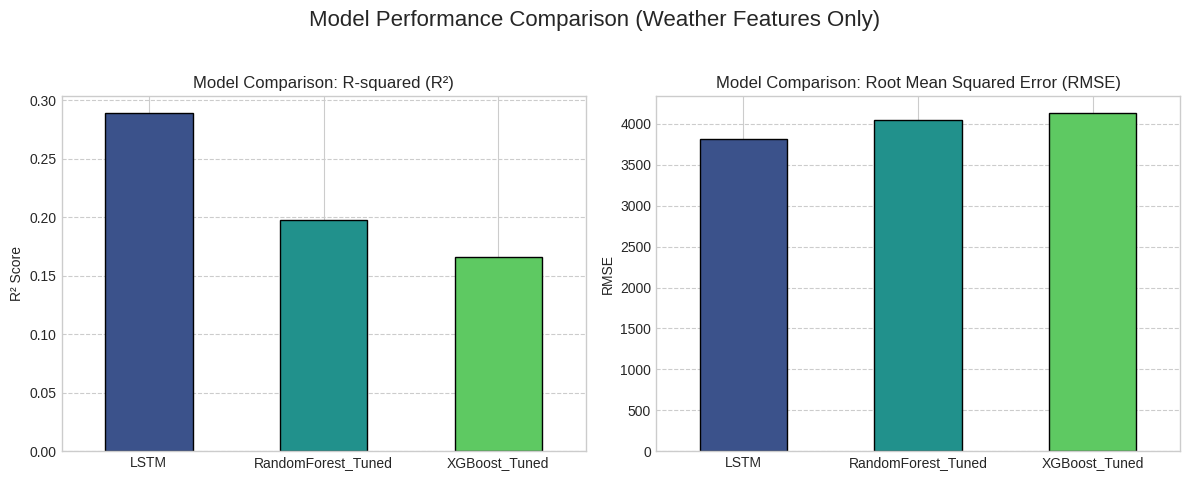

--- Model Comparison Section Complete ---


In [18]:
# %%
# 7.3 Final Model Comparison
print("\n--- 7.3 Final Model Comparison ---")

if model_results: # Check if the dictionary has results
    results_df = pd.DataFrame.from_dict(model_results, orient='index')
    results_df = results_df.sort_values(by='R2', ascending=False) # Sort by R2 score

    print("\nModel Comparison Summary:")
    print(results_df.to_string(float_format="%.4f"))

    # Plotting Comparison
    try:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False) # Create 2 subplots

        # Plot R2 Scores
        results_df['R2'].plot(kind='bar', ax=axes[0], color=sns.color_palette("viridis", len(results_df)), edgecolor='black')
        axes[0].set_title('Model Comparison: R-squared (R²)')
        axes[0].set_ylabel('R² Score')
        axes[0].tick_params(axis='x', rotation=0)
        axes[0].grid(axis='y', linestyle='--')

        # Plot RMSE Scores
        results_df['RMSE'].plot(kind='bar', ax=axes[1], color=sns.color_palette("viridis", len(results_df)), edgecolor='black')
        axes[1].set_title('Model Comparison: Root Mean Squared Error (RMSE)')
        axes[1].set_ylabel('RMSE')
        axes[1].tick_params(axis='x', rotation=0)
        axes[1].grid(axis='y', linestyle='--')

        plt.suptitle('Model Performance Comparison (Weather Features Only)', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
        plt.show()

    except Exception as e:
        print(f"\nError during comparison plotting: {e}")
        print("Displaying results table only.")

else:
    print("\nNo model results found to compare.")

# %%
print("--- Model Comparison Section Complete ---")